/var/folders/zy/lmbjt0ls4mdd8y8k61lksbhw0000gn/T/ipykernel_30138/929486109.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nino34.dropna(inplace=True)


ENSO: Index(['Date', 'NINO3.4'], dtype='object')
Nino 3.4 NPI: Index(['Date', 'NPI'], dtype='object')


"\n################################### Decade Time Series #########################################################################\n\n# Filter data between 1990 and 2000\n\nnino34_dec = nino34[(nino34['Date'].dt.year >= 1990) & (nino34['Date'].dt.year <= 2000)]\nnpi_dec = npi[(npi['Date'].dt.year >= 1990) & (npi['Date'].dt.year <= 2000)]\n\nfig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))\n\nax1.set_title('NOAA Extended Reconstruction Sea Surface Temperature (ERSST) - NINO 3.4 Region - 1990 - 2000')\nax1.scatter(nino34_dec['Date'], nino34_dec['NINO3.4'], color='orange')\nax1.set_ylabel('SST Index (C)')\nax1.tick_params(axis='y')\n\nax2.set_title('North Pacific Index (NPI) for Nino 3.4 Region - 1990 - 2000')\nax2.scatter(npi_dec['Date'], npi_dec['NPI'], color='darkblue')\nax2.set_ylabel('Pressure Index (psi)')\nax2.tick_params(axis='y')\n\nplt.xlabel('Date (year)')\nplt.tight_layout()\n\n# Save the plot\noutput_dir = '/Users/kboot/phy577_projects/hw6/figures/'\nplt.sa

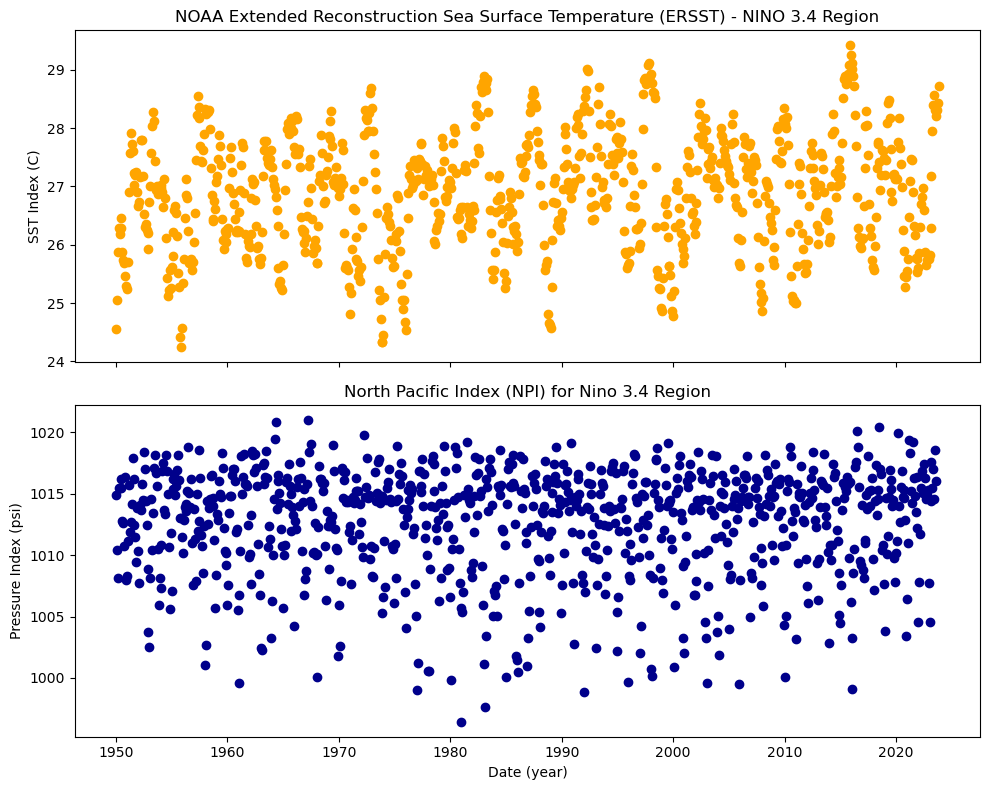

In [56]:
# 1. Download and ingest the two records, monthly sea-surface temperature T at ENSO-3.4 
# and monthly sea-level pressure p at NPI. Trim the records so that they overlap and appropriately 
# interpolate over or remove nan’s. 

'''
The El Nino Southern Oscillation-3.4 index is based on the average water temperature 
between −5◦-5◦ N and 170◦-120◦ W (left, Figure 1). When this region is anomalously warm, 
we are entering (or are in) an El Nin ̃o phase; whereas, when its anomalously cold, we’re 
in a La Nin ̃a phase. The North Pacific Index is based on the sea-level-pressure between 
30-60◦N and 160◦E-140◦W (contours, right, Figure 1). When the average atmospheric pressure 
over this region is low, the west-coast of the US gets more winter rainfall, and vice-versa. 
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from scipy.stats import skew
from matplotlib.offsetbox import AnchoredText
from datetime import timedelta
from scipy.stats import t
import os
from scipy.stats import norm
from scipy.signal import welch
from scipy.stats import chi2
from scipy.stats import linregress
from scipy.signal import csd, coherence



from obspy.signal.invsim import cosine_taper
#from mtspec import mtspec

##################################### Station Info & Import ###########################################3

url = "https://www.cpc.ncep.noaa.gov/data/indices/ersst5.nino.mth.91-20.ascii"
url2 = "https://climatedataguide.ucar.edu/sites/default/files/2023-10/npindex_monthly.txt"

enso = pd.read_csv(url, delim_whitespace=True)
enso.columns = ['YR', 'MON', 'NINO1+2', 'ANOM', 'NINO3', 'ANOM.1', 'NINO4', 'ANOM.2', 'NINO3.4', 'ANOM.3']
enso['Date'] = pd.to_datetime(enso['YR'].astype(str) + enso['MON'].astype(str).str.zfill(2), format='%Y%m')

nino34 = enso[['Date', 'NINO3.4']]
nino34.dropna(inplace=True)

npi = pd.read_csv(url2, delim_whitespace=True, skiprows=1, header=None)
npi = npi.iloc[:, :2]
npi.columns = ['Date', 'NPI']
npi['Date'] = pd.to_datetime(npi['Date'], format='%Y%m')
npi = npi[npi['NPI'] >= 500]
npi.dropna(inplace=True)

# Find a common date range
start = max(nino34['Date'].min(), npi['Date'].min())
end = min(nino34['Date'].max(), npi['Date'].max())

# Trim both datasets to the common date range
nino34 = nino34[(nino34['Date'] >= start) & (nino34['Date'] <= end)]
npi = npi[(npi['Date'] >= start) & (npi['Date'] <= end)]

print('ENSO:', nino34.columns)
print('Nino 3.4 NPI:', npi.columns)

# 2. Plot both records on separate axes. Describe the time-series (zoom in if needed). 
# What are their mean, and standard deviations, and zero-lagged correlation coefficient? 
# Is the correlation coefficient statistically significant? Use the Fisher-transformation from Lecture 5. 

################################### Plot Time Series #########################################################################

################################### Total Time Series #########################################################################

# Creating stacked subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

ax1.set_title('NOAA Extended Reconstruction Sea Surface Temperature (ERSST) - NINO 3.4 Region')
ax1.scatter(enso['Date'], enso['NINO3.4'], color='orange')
ax1.set_ylabel('SST Index (C)')
ax1.tick_params(axis='y')

ax2.set_title('North Pacific Index (NPI) for Nino 3.4 Region')
ax2.scatter(npi['Date'], npi['NPI'], color='darkblue')
ax2.set_ylabel('Pressure Index (psi)')
ax2.tick_params(axis='y')

plt.xlabel('Date (year)')
plt.tight_layout()

output_dir = '/Users/kboot/phy577_projects/hw6/figures/'
plt.savefig(os.path.join(output_dir, '1_timeseries_nino34.png'))
'''
################################### Decade Time Series #########################################################################

# Filter data between 1990 and 2000

nino34_dec = nino34[(nino34['Date'].dt.year >= 1990) & (nino34['Date'].dt.year <= 2000)]
npi_dec = npi[(npi['Date'].dt.year >= 1990) & (npi['Date'].dt.year <= 2000)]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

ax1.set_title('NOAA Extended Reconstruction Sea Surface Temperature (ERSST) - NINO 3.4 Region - 1990 - 2000')
ax1.scatter(nino34_dec['Date'], nino34_dec['NINO3.4'], color='orange')
ax1.set_ylabel('SST Index (C)')
ax1.tick_params(axis='y')

ax2.set_title('North Pacific Index (NPI) for Nino 3.4 Region - 1990 - 2000')
ax2.scatter(npi_dec['Date'], npi_dec['NPI'], color='darkblue')
ax2.set_ylabel('Pressure Index (psi)')
ax2.tick_params(axis='y')

plt.xlabel('Date (year)')
plt.tight_layout()

# Save the plot
output_dir = '/Users/kboot/phy577_projects/hw6/figures/'
plt.savefig(os.path.join(output_dir, '2_timeseries_1990-2000.png'))

# Filter data between 1995 and 2000

nino34_5 = nino34[(nino34['Date'].dt.year >= 1995) & (nino34['Date'].dt.year <= 2000)]
npi_5 = npi[(npi['Date'].dt.year >= 1995) & (npi['Date'].dt.year <= 2000)]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

ax1.set_title('NOAA Extended Reconstruction Sea Surface Temperature (ERSST) - NINO 3.4 Region - 1995 - 2000')
ax1.scatter(nino34_5['Date'], nino34_5['NINO3.4'], color='orange')
ax1.set_ylabel('SST Index (C)')
ax1.tick_params(axis='y')

ax2.set_title('North Pacific Index (NPI) for Nino 3.4 Region - 1995 - 2000')
ax2.scatter(npi_5['Date'], npi_5['NPI'], color='darkblue')
ax2.set_ylabel('Pressure Index (psi)')
ax2.tick_params(axis='y')

plt.xlabel('Date (year)')
plt.tight_layout()

output_dir = '/Users/kboot/phy577_projects/hw6/figures/'
plt.savefig(os.path.join(output_dir, '3_timeseries_1995-2000.png'))
'''

In [57]:
################################### Statistics #########################################################################

nino34_mean = nino34['NINO3.4'].mean()
nino34_std = nino34['NINO3.4'].std()

npi_mean = npi['NPI'].mean()
npi_std = npi['NPI'].std()

# Calculate zero-lagged correlation coefficient
corr_coef = np.corrcoef(nino34['NINO3.4'], npi['NPI'])[0, 1]

print("Dataset Statistics")
print("\nNINO3.4 SST Index:")
print(f"Mean: {nino34_mean:.2f} C")
print(f"Standard Deviation: {nino34_std:.2f}")

print("\nNPI:")
print(f"Mean: {npi_mean:.2f} psi")
print(f"Standard Deviation: {npi_std:.2f}")

print("\nZero-Lagged Correlation Coefficient:")
print(f"{corr_coef:.2f}")


############ Fisher Method ########################

# Fisher Transformation
ft = 0.5 * np.log((1 + corr_coef) / (1 - corr_coef))

# Standard Error
N = len(nino34)  

std_err = 1 / np.sqrt(N - 3)  # Formula for standard error for Pearson correlation coefficient

# Confidence Interval for Fisher Transformation

alpha = 0.05  # Significance level (e.g., 0.05 for 95% confidence interval)

crit = norm.ppf(1 - alpha / 2)  # Critical value for the normal distribution
ci = (ft - crit * std_err,
                       ft + crit * std_err)

# Check if zero is within the confidence interval
is_sig = ci[0] < 0 < ci[1]

print("Fisher Transformed Correlation:", round(ft, 3))
print("Standard Error:", round(std_err, 3))
print("Confidence Interval for Fisher Transformation:", ci)
print("Is Correlation Coefficient Significant:", is_sig)

'''
# Scatter plot of SST and Pressure
plt.scatter(nino34['NINO3.4'], npi['NPI'], color='orange', label='SST vs Pressure')
plt.xlabel('Monthly SST (C)')
plt.ylabel('Monthly Pressure (psi)')
plt.title('Monthly SST vs Monthly Pressure')

# linear regression
slope, intercept, r_value, p_value, std_err = linregress(nino34['NINO3.4'], npi['NPI'])
fit = slope * nino34['NINO3.4'] + intercept

# Plot the line of best fit
plt.plot(nino34['NINO3.4'], fit, color='red', label=f'y = {slope:.2f}x + {intercept:.2f}')
plt.text(0.7, 0.95, f'FT Correlation: {round(ft, 3)}', transform=plt.gca().transAxes)
plt.text(0.75, 0.9, f'Significant: {is_sig}', transform=plt.gca().transAxes)
plt.legend()

output_dir = '/Users/kboot/phy577_projects/hw6/figures/'
plt.savefig(os.path.join(output_dir, '0_LinReg.png'))
'''

Dataset Statistics

NINO3.4 SST Index:
Mean: 26.89 C
Standard Deviation: 0.98

NPI:
Mean: 1012.66 psi
Standard Deviation: 4.42

Zero-Lagged Correlation Coefficient:
0.10
Fisher Transformed Correlation: 0.101
Standard Error: 0.034
Confidence Interval for Fisher Transformation: (0.03542644940962576, 0.16749217824999924)
Is Correlation Coefficient Significant: False


"\n# Scatter plot of SST and Pressure\nplt.scatter(nino34['NINO3.4'], npi['NPI'], color='orange', label='SST vs Pressure')\nplt.xlabel('Monthly SST (C)')\nplt.ylabel('Monthly Pressure (psi)')\nplt.title('Monthly SST vs Monthly Pressure')\n\n# linear regression\nslope, intercept, r_value, p_value, std_err = linregress(nino34['NINO3.4'], npi['NPI'])\nfit = slope * nino34['NINO3.4'] + intercept\n\n# Plot the line of best fit\nplt.plot(nino34['NINO3.4'], fit, color='red', label=f'y = {slope:.2f}x + {intercept:.2f}')\nplt.text(0.7, 0.95, f'FT Correlation: {round(ft, 3)}', transform=plt.gca().transAxes)\nplt.text(0.75, 0.9, f'Significant: {is_sig}', transform=plt.gca().transAxes)\nplt.legend()\n\noutput_dir = '/Users/kboot/phy577_projects/hw6/figures/'\nplt.savefig(os.path.join(output_dir, '0_LinReg.png'))\n"

DOF: 36
CI: 0.236


"\nplt.figure(figsize=(10, 6))\nplt.loglog(f_T, Sxx, label='Auto-Spectrum SST', color='orange')\nplt.fill_between(f_T, S_T_low, S_T_upper, color='black', alpha=0.2)\n\nplt.loglog(f_P, Syy, label='Auto-Spectrum Pressure', color='darkblue')\nplt.fill_between(f_P, S_P_low, S_P_upper, color='black', alpha=0.2)\nplt.loglog(f, np.abs(S_TP), label='Cross-Spectrum SST-Pressure', color='darkred')\n\nplt.xlabel('Cyclic Frequency (cycles/year)')\nplt.ylabel('Spectral Density')\nplt.title('Auto-Spectra and Cross-Spectra with 95% Confidence Interval')\nplt.legend()\n\noutput_dir = '/Users/kboot/phy577_projects/hw6/figures/'\nplt.savefig(os.path.join(output_dir, '6_ConInt.png'))\n"

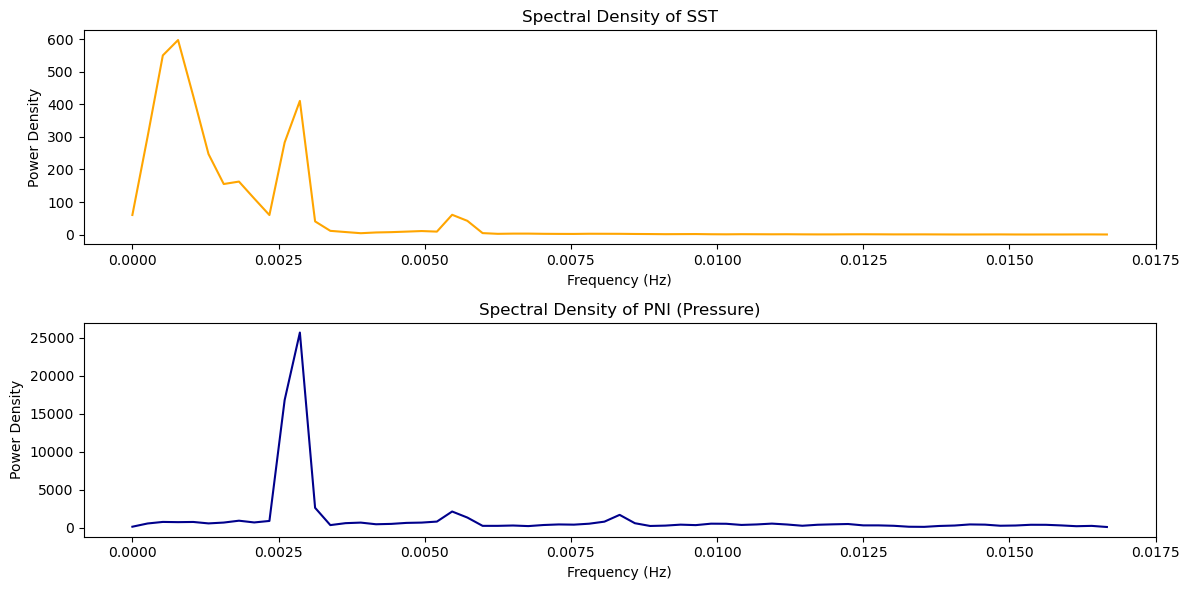

In [58]:
############################################ Auto spectral density functions ##############################################

# 3. Estimate the auto-spectral density functions STT & Spp for each record, using M = 18 windows 
# each with Nc = 128 data-points and β = 2/3 overlap. How many degrees of freedom do you have? 
# Estimate the corresponding 95% confidence interval. 

# Sampling frequency for monthly data (in Hz)
SF = 1 / 30  # Once per month

M = 18  # Number of windows
Nc = 128  # Data points in each window
beta = 2/3  # Overlap factor
noverlap = int(Nc * beta)  # Overlap in points

# Extract the SST and Pressure values
SST = nino34['NINO3.4'].values
Pr = npi['NPI'].values

# Calculate spectral densities using Welch's method
f_T, Sxx = welch(SST, fs=SF, nperseg=Nc, noverlap=noverlap)
f_P, Syy = welch(Pr, fs=SF, nperseg=Nc, noverlap=noverlap)

#################################### Plot Auto-Spectral densities ################################################

# Plot the Spectral Densities
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(f_T, Sxx, color='orange')
plt.title('Spectral Density of SST')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Density')

# Plotting Spectral Density for PNI
plt.subplot(2, 1, 2)
plt.plot(f_T, Syy, color='darkblue')
plt.title('Spectral Density of PNI (Pressure)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Density')

plt.tight_layout()

output_dir = '/Users/kboot/phy577_projects/hw6/figures/'
plt.savefig(os.path.join(output_dir, '4_AutoSpec_best .png'))


################################### Cross Spectral Density ########################################################

# Calculate Cross-Spectral Density between SST and Pressure
f, S_TP = csd(SST, Pr, fs=SF, nperseg=Nc, noverlap=noverlap)

'''
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 2)
plt.plot(f, S_TP, color='darkred')
plt.title('Cross-Spectral Density of SST and PNI (Pressure)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Density')

plt.tight_layout()

output_dir = '/Users/kboot/phy577_projects/hw6/figures/'
plt.savefig(os.path.join(output_dir, '5_CrossSpec.png'))

'''

################################### Confidence Intervals #############################################################

# Degrees of freedom

dof = 2 * M

# Convert frequency to cycles/year
f_T *= 12
f_P *= 12
f *= 12

# Calculate 95% confidence intervals

CI = np.sqrt(2 / dof)
S_T_low = Sxx * (1 - CI)
S_T_upper = Sxx * (1 + CI)
S_P_low = Syy * (1 - CI)
S_P_upper = Syy * (1 + CI)

print("DOF:", dof)
print('CI:', CI.round(3))

'''
plt.figure(figsize=(10, 6))
plt.loglog(f_T, Sxx, label='Auto-Spectrum SST', color='orange')
plt.fill_between(f_T, S_T_low, S_T_upper, color='black', alpha=0.2)

plt.loglog(f_P, Syy, label='Auto-Spectrum Pressure', color='darkblue')
plt.fill_between(f_P, S_P_low, S_P_upper, color='black', alpha=0.2)
plt.loglog(f, np.abs(S_TP), label='Cross-Spectrum SST-Pressure', color='darkred')

plt.xlabel('Cyclic Frequency (cycles/year)')
plt.ylabel('Spectral Density')
plt.title('Auto-Spectra and Cross-Spectra with 95% Confidence Interval')
plt.legend()

output_dir = '/Users/kboot/phy577_projects/hw6/figures/'
plt.savefig(os.path.join(output_dir, '6_ConInt.png'))
'''

884
884
CC between LPS SST and Pressure: 0.0714


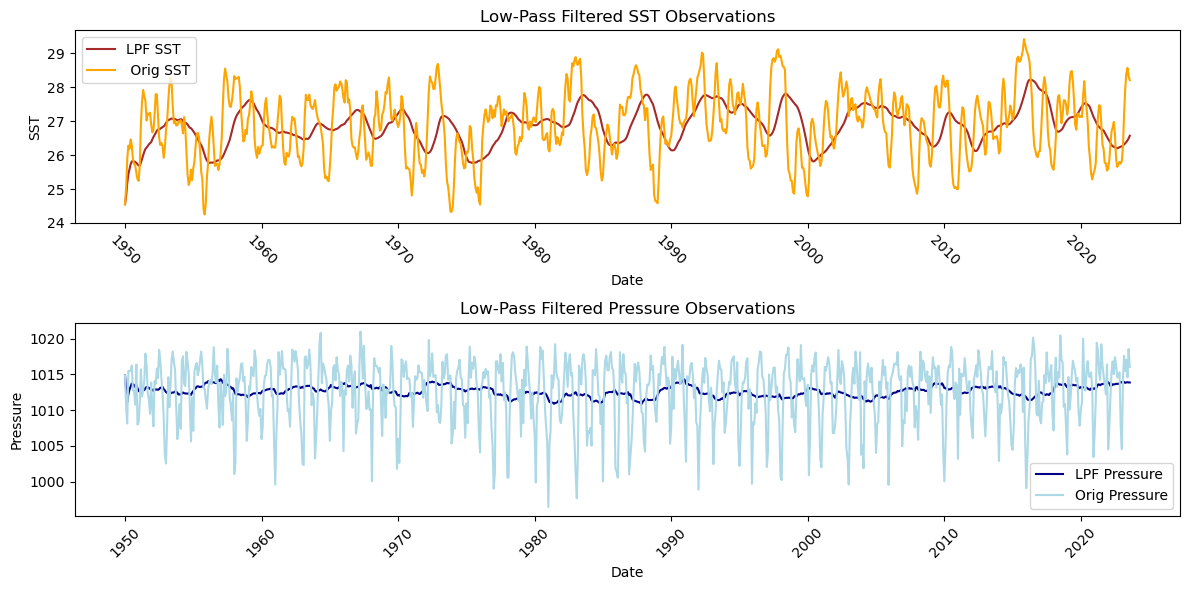

In [100]:
# Plot the coherence γˆ2 and phase ϕˆ on a linear scale versus frequency on a log10 scale

# Compute coherence and phase
f, Cxy = coherence(SST, Pr, fs=SF, nperseg=Nc, noverlap=noverlap)

_, S_TP = csd(SST, Pr, fs=SF, nperseg=Nc, noverlap=noverlap)

#f, S_TP = csd(SST, Pr, fs=SF, nperseg=Nc, noverlap=noverlap)

phase = np.angle(S_TP)

# 95% confidence threshold for zero coherence

CT95 = 1 - (0.05 ** (1 / (dof / 2 - 1)))

'''
plt.figure(figsize=(10, 6))
plt.semilogx(f * 12, Cxy, label='Coherence', color='orange')  
plt.axhline(y=CT95, color='darkred', linestyle='--', label='95% Confidence Threshold')
plt.semilogx(f * 12, np.unwrap(phase), label='Phase', color='green')

# Coherence error bars
error = np.sqrt(1 / dof) * Cxy
Cxy_upper = Cxy + error
Cxy_lower = Cxy - error
Cxy_lower[Cxy_lower < 0] = 0  # Coherence cannot be negative
plt.fill_between(f * 12, Cxy_lower, Cxy_upper, where=Cxy > CT95, color='orange', alpha=0.2)

plt.xlabel('Cyclic Frequency (cycles/year)')
plt.ylabel('Coherence / Phase')
plt.title('Coherence and Phase vs Frequency')
plt.legend()

output_dir = '/Users/kboot/phy577_projects/hw6/figures/'
plt.savefig(os.path.join(output_dir, '7_CoherencePhase.png'))
'''

################################# Filtering Data #######################################################

window_size = 24  # 12 months/year * 2 years = 24 months

def low_pass(data, window_size):
    return data.rolling(window=window_size, min_periods=1).mean()

enso['LP'] = low_pass(enso['NINO3.4'], window_size)
npi['LP'] = low_pass(npi['NPI'], window_size)

# Find the date range that is common to both datasets
start = max(enso['Date'].min(), npi['Date'].min())
end = min(enso['Date'].max(), npi['Date'].max())

# Filter both datasets to cover the same time periods
enso = enso[(enso['Date'] >= start) & (enso['Date'] <= end)]
npi = npi[(npi['Date'] >= start) & (npi['Date'] <= end)]

enso.dropna(subset=['LP'], inplace=True)
npi.dropna(subset=['LP'], inplace=True)

print(len(enso['LP']))
print(len(npi['LP']))


# Check variance
#print("Variance in SST:", enso['LP'].var())
#print("Variance in Pressure:", npi['LP'].var())

############# new corr coeff for LP #####################

# Calculate the correlation coefficient between low-pass filtered SST and Pressure
CClp = enso['LP'].corr(npi['LP'])
print(f"CC between LPS SST and Pressure: {CClp.round(4)}")


plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(enso['Date'], enso['LP'], color='brown', label='LPF SST')
plt.plot(enso['Date'], enso['NINO3.4'], color='orange', label=' Orig SST')
plt.xlabel('Date')
plt.ylabel('SST')
plt.title('Low-Pass Filtered SST Observations')
plt.legend()
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=315)

plt.subplot(2, 1, 2)
plt.plot(npi['Date'], npi['LP'], color='darkblue', label='LPF Pressure')
plt.plot(npi['Date'], npi['NPI'], color='lightblue', label='Orig Pressure')
plt.xlabel('Date')
plt.ylabel('Pressure')
plt.title('Low-Pass Filtered Pressure Observations')
plt.legend()
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()

output_dir = '/Users/kboot/phy577_projects/hw6/figures/'
plt.savefig(os.path.join(output_dir, '8_LPFObs.png'))

In [29]:
################################# Auto-Spectro Density Alternative Method? ############################################

''' ##### Alternative Method I used until Carter helped me out 
# Parameters
M = 18  # Number of windows
Nc = 128  # Number of data points in each window
beta = 2 / 3  # Overlap 

N = len(nino34['NINO3.4'])

# Initialize arrays to store PSD and frequency values
psd_nino34 = np.zeros(N)
psd_npi = np.zeros(N)
freq_nino34 = np.fft.fftfreq(N)
freq_npi = np.fft.fftfreq(N)

# Calculate window size and overlap
window_size = N // M
overlap = int(beta * Nc)

# Calculate FFT and PSD for each window
for i in range(M):
    start_idx = i * (Nc - overlap)  # Start index for each window considering overlap
    end_idx = min(start_idx + Nc, N)  # End index for each window

    # Calculate FFT for the window
    fft_nino34 = np.fft.fft(nino34['NINO3.4'][start_idx:end_idx], n=Nc)
    fft_npi = np.fft.fft(npi['NPI'][start_idx:end_idx], n=Nc)

    # Calculate PSD for the window
    psd_nino34[start_idx:end_idx] = np.abs(fft_nino34) ** 2
    psd_npi[start_idx:end_idx] = np.abs(fft_npi) ** 2

# Display the results (only displaying the frequencies for the first window)
# print("Frequency (NINO3.4):", np.fft.fftfreq(Nc))
# print("Frequency (NPI):", np.fft.fftfreq(Nc))
'''


'''
Power spectral density (PSD) calculated using the Fast Fourier Transform (FFT) 
--> PSD = distribution of power (or energy) of a signal across different frequencies. 
--> PSD provides information about the strength of the signal at various frequencies.
--> estimates the auto-spectral density function for a given time series. 

The auto-spectral density function describes how the power of a signal is distributed across different frequencies. 
Therefore, when you compute the PSD using the FFT on a time series, you are effectively estimating the auto-spectral density
function for that signal.

'''
'''
deg = (2 * M * Nc) / (Nc + (beta * (N - Nc)))

print("Degrees of Freedom:", round(deg))

# Calculate critical values from chi-squared distribution

alpha = 0.05  # Significance level (1 - 95%)

crit_lower = chi2.ppf(alpha / 2, deg)
crit_upper = chi2.ppf(1 - alpha / 2, deg)

# Calculate confidence interval for PSD
CI = [round(crit_lower, 3), round(crit_upper, 3)]

print("95% Confidence Interval:", CI)

'''

'\ndeg = (2 * M * Nc) / (Nc + (beta * (N - Nc)))\n\nprint("Degrees of Freedom:", round(deg))\n\n# Calculate critical values from chi-squared distribution\n\nalpha = 0.05  # Significance level (1 - 95%)\n\ncrit_lower = chi2.ppf(alpha / 2, deg)\ncrit_upper = chi2.ppf(1 - alpha / 2, deg)\n\n# Calculate confidence interval for PSD\nCI = [round(crit_lower, 3), round(crit_upper, 3)]\n\nprint("95% Confidence Interval:", CI)\n\n'

In [6]:
########################################## Cross-spectral Density functions ###########################################3

# 4. Estimate the cross-spectral density function STp for each record, using the same {M, Nc, β}. 1 
'''
# Parameters
M = 18  # Number of windows
Nc = 128  # Number of data points in each window
beta = 2 / 3  # Overlap 
N = len(nino34['NINO3.4'])
n = len(npi['NPI'])

print(N)
print(n)
'''

'''
#### Welch's method
# Parameters
M = 18  # Number of windows
Nc = 128  # Number of data points in each window
beta = 2 / 3  # Overlap 

# Calculate CPSD using Welch's method
frequencies, cpsd = welch(nino34['NINO3.4'], npi['NPI'], nperseg=Nc, noverlap=int(beta * Nc))


# Alternative --> Lomb-Scargle periodogram for cross-spectral density

from astropy.timeseries import LombScargle

times = npi_5['Date']

ls = LombScargle(times, nino34['NINO3.4'])
frequency, power = ls.autopower()

ls_npi = LombScargle(times, npi['NPI'])
frequency_npi, power_npi = ls_npi.autopower()
'''

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (72,) and arg 1 with shape (884,).

Degrees of Freedom: 7
95% Confidence Interval: [1.829, 16.46]


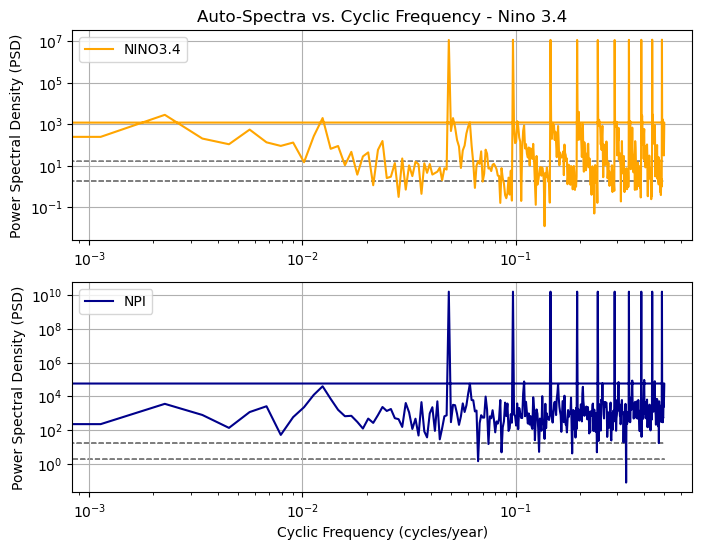

In [15]:
# 5. Plot your auto-spectra and cross-spectra versus cyclic frequency (in cycles/year) on the same log-log axes, include your confidence interval.

###################################### Plot auto-spectral density #####################################################


deg = (2 * M * Nc) / (Nc + (beta * (N - Nc)))

print("Degrees of Freedom:", round(deg))

# Calculate critical values from chi-squared distribution

alpha = 0.05  # Significance level (1 - 95%)

crit_lower = chi2.ppf(alpha / 2, deg)
crit_upper = chi2.ppf(1 - alpha / 2, deg)

# Calculate confidence interval for PSD
CI = [round(crit_lower, 3), round(crit_upper, 3)]

print("95% Confidence Interval:", CI)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot auto-spectra for 'NINO3.4'
ax1.loglog(freq_nino34, psd_nino34, label='NINO3.4', color='orange')
ax2.loglog(freq_npi, psd_npi, label='NPI', color='darkblue')
ax1.fill_between(freq_nino34, crit_lower, crit_upper, alpha=0.5, color='black', linestyle='--')
ax2.fill_between(freq_npi, crit_lower, crit_upper, alpha=0.5, color='black', linestyle='--')

# Plot settings
ax1.set_ylabel('Power Spectral Density (PSD)')
ax1.set_title('Auto-Spectra vs. Cyclic Frequency - Nino 3.4')
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('Cyclic Frequency (cycles/year)')
ax2.set_ylabel('Power Spectral Density (PSD)')
ax2.legend()
ax2.grid(True)

output_dir = '/Users/kboot/phy577_projects/hw6/figures/'
plt.savefig(os.path.join(output_dir, '4_autospectralVfreq.png'))

# 6. Describe the auto-spectra:
    # are they red, white or blue?
    # do they have any significant peaks? If so, at what time-scales
    # Are there any peaks in the cross-spectrum that are different than either auto-spectrum?

In [ ]:


    
# 7. Plot the coherence γˆ2 and phase φˆ on a linear scale versus frequency on a log10 scale. Estimate the threshold for 95% bound on a truly zero coherence γ2 = 0. Only over the regions where γˆ2 is larger than this threshold, estimate and plot error bars for the 95%-CI bounds for the estimate.
# 8. Are there any frequencies with significant coherence? What are the corresponding time-scales? De- scribe the patterns in coherence, and the corresponding phase. What is the phase for time-scales longer than 5 years? How does this relate to the T and p anomolies, e.g., at these time-scales when T′ =T−T ̄>0thenp′ =p−p ̄????
# 9. Low-pass filter the records, Tlp = T ⋆ w & plp = p ⋆ w, to remove variations on time-scales shorter than 2-years. Plot them similar to question (2) above. What is the correlation coefficient between the low-passed records? How does this compare to the coherence estimate γˆ2? Is the relationsip between
# T ′ and p′ consistent with your rational in question (9)? Explain why/not. lp lp